In [56]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import json

In [2]:
# Загружаем подготовленные данные 
x_train = np.load('data/x_train.npy')
y_train = np.load('./data/y_train.npy')
x_test = np.load('./data/x_val.npy')
y_test = np.load('./data/y_val.npy')

In [3]:
# Строим модель

def build_model():
    x = tf.keras.Input((256, 256, 3))
    
    out = tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    out1 = tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu')(out)
    out =  tf.keras.layers.MaxPool2D((2,2))(out1)
        
    out = tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu')(out)
    out2 = tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu')(out)
    out =  tf.keras.layers.MaxPool2D((2,2))(out2)
    
        
    out = tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu')(out)
    out3 = tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu')(out)
    out =  tf.keras.layers.MaxPool2D((2,2))(out3)
    
        
    out = tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu')(out)
    out4 = tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu')(out)
    out =  tf.keras.layers.MaxPool2D((2,2))(out4)
    
    out = tf.keras.layers.Conv2D(1024, (3,3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1024, (3,3), padding='same', activation='relu')(out)
    
    out = tf.keras.layers.Conv2DTranspose(512, (3,3), strides=(2,2), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3)
    
    out = tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu')(out)
    
    out = tf.keras.layers.Conv2DTranspose(256, (3,3), strides=(2,2), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)
    
    out = tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu')(out)
    
    out = tf.keras.layers.Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)
    
    out = tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu')(out)
    
    out = tf.keras.layers.Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)
    
    out = tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu')(out)
    # Выбираем softmax, так как формально класса 2 - пины и фон 
    out = tf.keras.layers.Conv2D(2, (3,3), padding='same', activation='softmax')(out)
    
    return  tf.keras.Model(inputs = x, outputs = out)
    
model = build_model()

In [4]:
# воссоздаем модель 

model = build_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.load_weights('./data/U-net/weights.hdf5')

In [223]:
def show_cnt(img_: np.array, mod: str):
    
    def dumping_json(cen_sorted: np.array):
        
        rec = [[[cnt[0] - 5, cnt[1] - 5],
                [cnt[0] + 5, cnt[1] + 5]] for cnt in cen_sorted]
        
        json_dict = {}
        
        for num, item in enumerate(rec):
            json_dict[num] = list(item)
            
        with open('pins.json', 'w') as f:
            json.dump(json_dict, f)
    
    width, height = img_.shape[:2]
    
    img = cv2.resize(img_, (256, 256))
    
    kx, ky = width / 256, height / 256 
    
    
    
    
    
    ttt = img_.copy()
    
    
    det = model.predict(img[None, ...])[0,...][:,:,1]
    det = np.where(det > 0.021, 255, 0)

    contours, _ = cv2.findContours(
        det.copy(),
        cv2.RETR_FLOODFILL ,cv2.CHAIN_APPROX_SIMPLE)

    centers = list()
    for cnt in contours[0:-1:2]:
        if cv2.contourArea(cnt) > 200 and( cnt.mean(axis=0)[0][0] > 175 or cnt.mean(axis=0)[0][0] < 75):
            centers.append(cnt.mean(axis=0))
            
    centers = np.array(centers).reshape(-1,2)
    centers[:, 0] = centers[:, 0] * ky
    centers[:, 1] = centers[:, 1] * kx
    
    
    if mod == "rt":
        cen_sorted = sorted(
            centers[centers[:, 0] > 128], key = lambda x : x[1]
      ) + sorted(
            centers[centers[:, 0] < 128], key = lambda x : x[1], reverse=True
      )
        
        dumping_json(cen_sorted = cen_sorted)
        return centers
        
    if mod == "rb": 
        cen_sorted = sorted(
            centers[centers[:, 0] > 128], key = lambda x : x[1], reverse = True
      ) + sorted(
            centers[centers[:, 0] < 128], key = lambda x : x[1],
      )
        
        dumping_json(cen_sorted = cen_sorted)
        
    if mod == "lt": 
        cen_sorted = sorted(
            centers[centers[:, 0] < 128], key = lambda x : x[1], reverse = True
      ) + sorted(
            centers[centers[:, 0] > 128], key = lambda x : x[1],
      )
        
        dumping_json(cen_sorted = cen_sorted)
        
    if mod == "lb": 
        cen_sorted = sorted(
            centers[centers[:, 0] < 128], key = lambda x : x[1], 
      ) + sorted(
            centers[centers[:, 0] > 128], key = lambda x : x[1], reverse = True
      )
        
        dumping_json(cen_sorted = cen_sorted)

        
    
        
        
        

    
        
        
    


In [227]:
img = cv2.resize(x_train[1], (200, 200))
cen = show_cnt(img, 'rt')


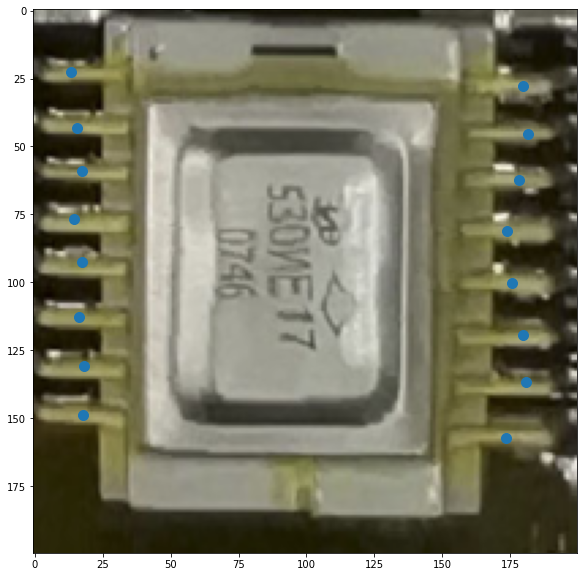

In [228]:
plt.figure(figsize=(10,10))
plt.imshow(img)

plt.scatter(cen[:,0], cen[:,1], marker = 'o', s=100)